In [2]:
import pandas as pd

file_paths = {
    "AD": 'uva-relevance-windows-ad.csv',
    "BrabantsDagblad": 'uva-relevance-windows-brabantsdagblad.csv',
    "NU.nl": 'uva-relevance-windows-nu.csv',
    "DeStentor": 'uva-relevance-windows-destentor.csv',
    "Volkskrant": 'uva-relevance-windows-volkskrant.csv',
    "Trouw": 'uva-relevance-windows-trouw.csv',
    "Parool": 'uva-relevance-windows-parool.csv',
}

# Opslaan van alle DataFrames in een dictionary
dataframes = {}

for name, path in file_paths.items():
    data = pd.read_csv(path, sep=';')
    dataframes[name] = pd.DataFrame(data)  # Elke dataset wordt opgeslagen met de naam als sleutel

# Eerste paar rijen bekijken van elke DataFrame
for name, df in dataframes.items():
    print(f"Eerste paar rijen van {name}:")
    print(df.head())
    print()

Eerste paar rijen van AD:
  article_id brand      publication_timestamp publication_weekday  \
0   237bd1f6    ad  2024-05-01 00:42:30+00:00            woensdag   
1    d41001b    ad  2024-05-01 00:43:33+00:00            woensdag   
2    a091b86    ad  2024-05-01 00:45:29+00:00            woensdag   
3    919c5e9    ad  2024-05-01 00:55:06+00:00            woensdag   
4    ba0a762    ad  2024-05-01 01:00:06+00:00            woensdag   

                                               title  \
0  Brand in portiekwoning op Hannemanstraat in De...   
1        Auto uitgebrand op Craubeekstraat in Arnhem   
2  Prinses Beatrix (86) krijgt eigen musical in n...   
3          Brand in auto op Hulstwede in Barendrecht   
4  Opinie stadsdeelbestuurder Zuidoost: ‘Hier in ...   

                                     first_paragraph  \
0  Woensdagnacht is brand in een woning uitgebrok...   
1  De brandweer is in de nacht van dinsdag op woe...   
2  Productiehuis MediaDome werkt aan een musical ...  

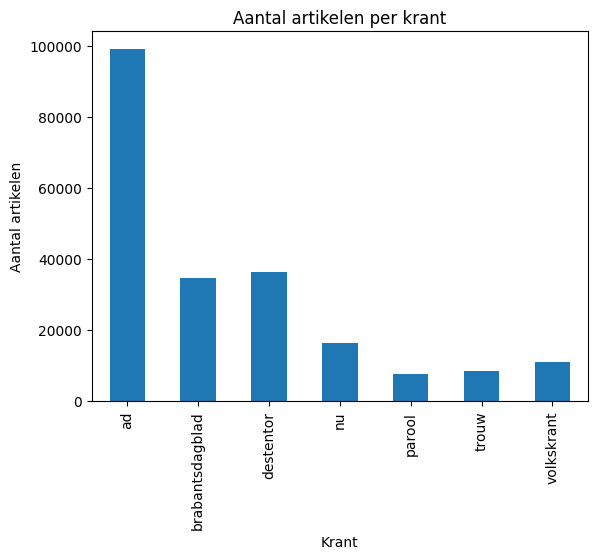

In [3]:
import matplotlib.pyplot as plt

# Aantal artikelen per krant
article_counts = pd.concat(dataframes.values()).groupby("brand").size()
article_counts.plot(kind="bar")
plt.title("Aantal artikelen per krant")
plt.ylabel("Aantal artikelen")
plt.xlabel("Krant")
plt.show()

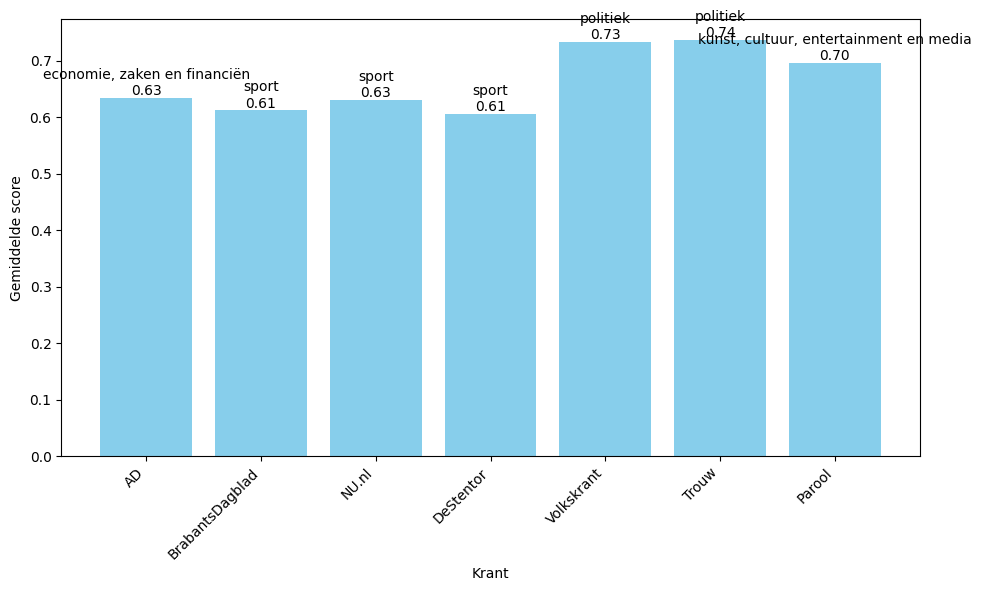

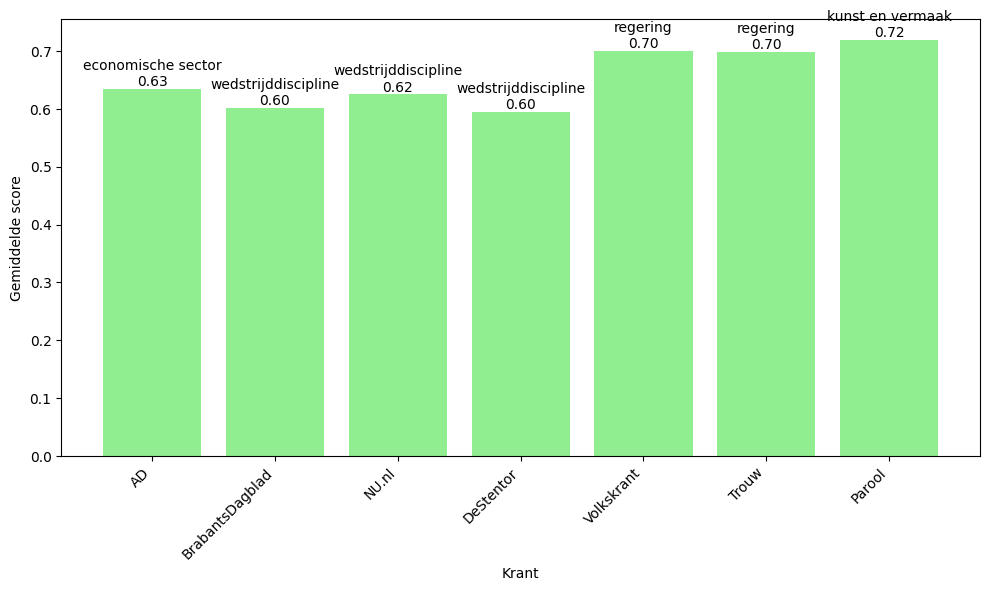

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

# Function to extract the dominant topics and calculate average scores
def extract_dominant_topic(data, level_column):
    data[level_column] = data[level_column].apply(
        lambda x: x if isinstance(x, dict) else ast.literal_eval(x)
    )
    data[level_column] = data[level_column].apply(lambda x: x if x else {"onbekend": 0})
    data[f'dominant_topic_{level_column}'] = data[level_column].apply(lambda x: max(x, key=x.get))
    data[f'average_score_{level_column}'] = data[level_column].apply(lambda x: sum(x.values()) / len(x) if x else 0)
    return data


# Initialize lists for storing results
results_level_0 = []
results_level_1 = []

# Process each file
for newspaper, path in file_paths.items():
    try:
        # Load the dataset
        data = pd.read_csv(path, delimiter=';', engine='python', on_bad_lines='skip')

        # Extract dominant topics and average scores for Level 0 and Level 1
        data = extract_dominant_topic(data, 'iptc_topics_level_0')
        data = extract_dominant_topic(data, 'iptc_topics_level_1')

        # Calculate the most frequent topics and their average scores
        most_frequent_level_0 = data['dominant_topic_iptc_topics_level_0'].value_counts().idxmax()
        avg_score_level_0 = data.loc[data['dominant_topic_iptc_topics_level_0'] == most_frequent_level_0, f'average_score_iptc_topics_level_0'].mean()

        most_frequent_level_1 = data['dominant_topic_iptc_topics_level_1'].value_counts().idxmax()
        avg_score_level_1 = data.loc[data['dominant_topic_iptc_topics_level_1'] == most_frequent_level_1, f'average_score_iptc_topics_level_1'].mean()

        # Add results for visualization
        results_level_0.append({"Newspaper": newspaper, "Topic": most_frequent_level_0, "Average Score": avg_score_level_0})
        results_level_1.append({"Newspaper": newspaper, "Topic": most_frequent_level_1, "Average Score": avg_score_level_1})

    except Exception as e:
        print(f"Error processing file {path} for {newspaper}: {e}")

# Convert results to DataFrames
results_df_level_0 = pd.DataFrame(results_level_0)
results_df_level_1 = pd.DataFrame(results_level_1)

# Plot for Level 0
plt.figure(figsize=(10, 6))
plt.bar(results_df_level_0['Newspaper'], results_df_level_0['Average Score'], color='skyblue')
for i, row in results_df_level_0.iterrows():
    plt.text(i, row['Average Score'], f"{row['Topic']}\n{row['Average Score']:.2f}", ha='center', va='bottom')

plt.ylabel('Gemiddelde score')
plt.xlabel('Krant')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot for Level 1
plt.figure(figsize=(10, 6))
plt.bar(results_df_level_1['Newspaper'], results_df_level_1['Average Score'], color='lightgreen')
for i, row in results_df_level_1.iterrows():
    plt.text(i, row['Average Score'], f"{row['Topic']}\n{row['Average Score']:.2f}", ha='center', va='bottom')

plt.ylabel('Gemiddelde score')
plt.xlabel('Krant')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


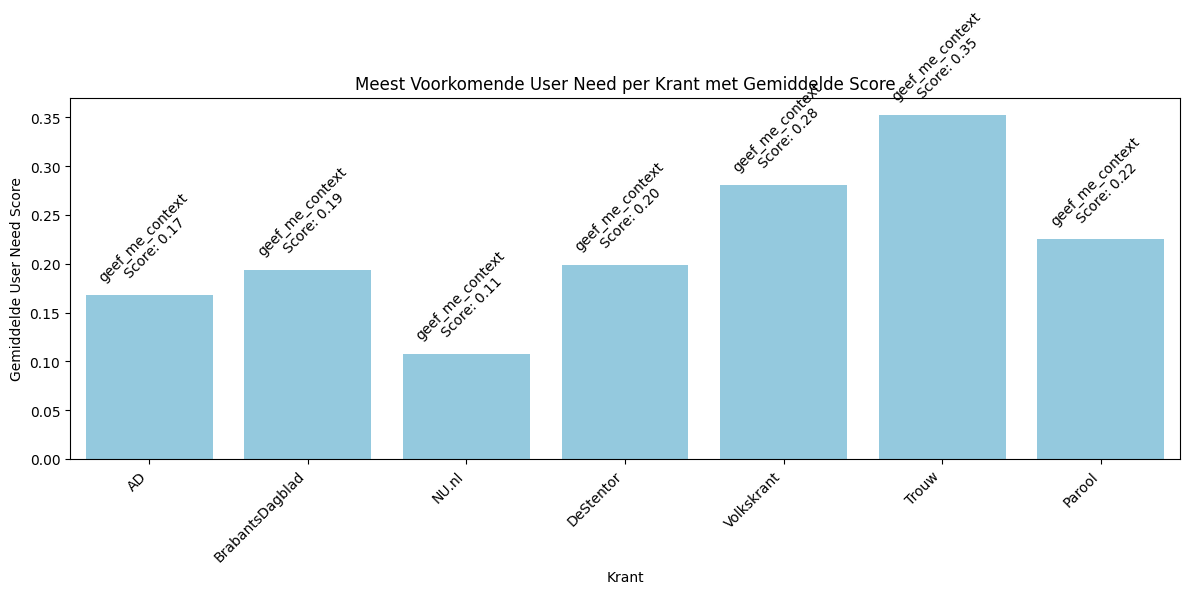

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# Functie om de meest voorkomende user need en gemiddelde score per krant te bepalen
def extract_most_frequent_user_need(data, column='user_needs'):
    user_need_counts = {}
    user_need_scores = {}
    
    for needs in data[column].dropna():
        try:
            # Converteer de string naar een dictionary
            needs_dict = ast.literal_eval(needs)
            for need, score in needs_dict.items():
                user_need_counts[need] = user_need_counts.get(need, 0) + 1
                user_need_scores[need] = user_need_scores.get(need, []) + [score]
        except Exception as e:
            print(f"Fout bij het verwerken van user needs: {e}")

    # Selecteer de meest voorkomende user need en de gemiddelde score
    if user_need_counts:
        most_frequent = max(user_need_counts, key=user_need_counts.get)
        avg_score = sum(user_need_scores[most_frequent]) / len(user_need_scores[most_frequent])
        return most_frequent, avg_score
    else:
        return "Onbekend", 0


# Lijst om de resultaten op te slaan
results = []

# Doorloop alle kranten en verzamel data
for newspaper, path in file_paths.items():
    try:
        # Lees het CSV-bestand
        data = pd.read_csv(path, delimiter=';', engine='python', on_bad_lines='skip')

        # Bepaal de meest voorkomende user need en gemiddelde score
        most_frequent_need, avg_score = extract_most_frequent_user_need(data)

        # Voeg toe aan de resultatenlijst
        results.append({
            "Newspaper": newspaper, 
            "Most Frequent User Need": most_frequent_need, 
            "Average Score": avg_score
        })

    except Exception as e:
        print(f"Fout bij het verwerken van {newspaper}: {e}")

# Zet de resultaten om in een DataFrame
results_df = pd.DataFrame(results)

# Plot de resultaten
plt.figure(figsize=(12, 6))
bars = sns.barplot(data=results_df, x='Newspaper', y='Average Score', color='skyblue')

# Annotaties toevoegen met de meest voorkomende user need en gemiddelde score
for bar, user_need, avg_score in zip(bars.patches, results_df['Most Frequent User Need'], results_df['Average Score']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
             f"{user_need}\nScore: {avg_score:.2f}",
             ha='center', va='bottom', fontsize=10, color='black', rotation=45)

plt.title('Meest Voorkomende User Need per Krant met Gemiddelde Score')
plt.xlabel('Krant')
plt.ylabel('Gemiddelde User Need Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Toon de grafiek
plt.show()
